In [ ]:
# Install & Import Libraries
!pip install datasets nltk wordcloud

# Core libraries
import pandas as pd
import numpy as np

# Hugging Face dataset loader
from datasets import load_dataset

# NLP libraries
import nltk
import re
import string

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt_tab")

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Load dataset
dataset = load_dataset("polsci/fake-news")

# Convert to DataFrame
df = pd.DataFrame(dataset["train"])

df.head()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/236k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/480 [00:00<?, ? examples/s]

,text,label
0,Protesters Disrupt DeVos School Visit\n\n\nPro...,0
1,_Impossible Foods to supersize production of l...,0
2,What to expect from Carrie Fisher and Debbie ...,0
3,Elton John celebrates 70th birthday with star...,0
4,Indian Wells: Roger Federer beats Stan Wawrin...,0


Dataset shape: (480, 2)


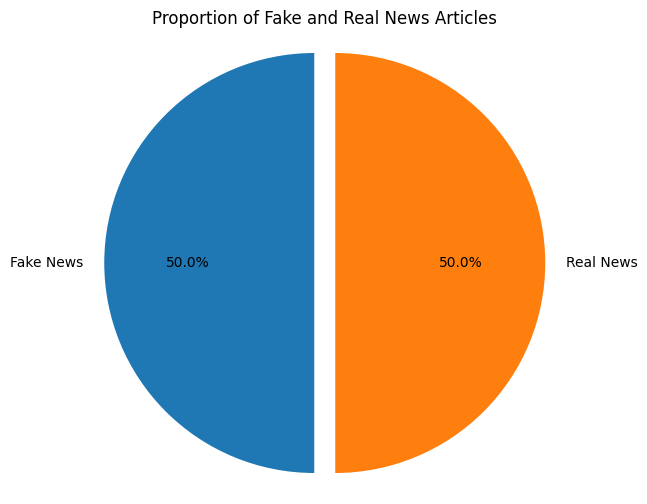

In [ ]:
# Dataset shape
print("Dataset shape:", df.shape)

# Descriptive visualisation
label_count = df['label'].value_counts() # Count of each class

labels = ['Fake News', 'Real News'] # labels to news articles

plt.figure(figsize=(6,6)) # plot the count
plt.pie(
    label_count,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    explode=(0.05, 0.05)
)
plt.title('Proportion of Fake and Real News Articles')
plt.axis('equal')
plt.show()

In [ ]:
# Text Preprocessing
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    tokens = word_tokenize(text)
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word.isalpha() and word not in stop_words
    ]
    return " ".join(tokens)

# Apply pre-processing function
df["clean_text"] = df["text"].apply(preprocess_text)
df[["text", "clean_text"]].head()

,text,clean_text
0,Protesters Disrupt DeVos School Visit\n\n\nPro...,protester disrupt devos school visit protester...
1,_Impossible Foods to supersize production of l...,impossible food supersize production labgrown ...
2,What to expect from Carrie Fisher and Debbie ...,expect carrie fisher debbie reynolds public me...
3,Elton John celebrates 70th birthday with star...,elton john celebrates birthday starstudded par...
4,Indian Wells: Roger Federer beats Stan Wawrin...,indian well roger federer beat stan wawrinka w...


In [ ]:
# Train_test_split

X = df["clean_text"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [ ]:
# Feature Extraction (TF-IDF)
tfidf = TfidfVectorizer(
    max_features=3000,
    ngram_range=(1, 2)
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

In [ ]:
# Rule-Based Classifier (Baseline)
fake_keywords = [
    "fake", "hoax", "fraud", "conspiracy",
    "lie", "scam", "deception", "misleading"
]

def rule_based_classifier(text):
    for word in fake_keywords:
        if word in text:
            return 1  # Fake
    return 0  # Legit

rule_preds = X_test.apply(rule_based_classifier)

In [ ]:
# Logistics Regression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

lr_preds = lr.predict(X_test_tfidf)

In [ ]:
# Support Vector Machine (SVM)

svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

svm_preds = svm.predict(X_test_tfidf)

In [ ]:
# Evaluation Metrics
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1-score :", f1_score(y_true, y_pred))
    print("ROC-AUC scpre :", roc_auc_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# Performance evaluation
evaluate_model("Rule-Based", y_test, rule_preds)
evaluate_model("Logistic Regression", y_test, lr_preds)
evaluate_model("SVM", y_test, svm_preds)


Rule-Based
Accuracy : 0.4583333333333333
Precision: 0.4
Recall   : 0.16666666666666666
F1-score : 0.23529411764705882
ROC-AUC scpre : 0.4583333333333333
Confusion Matrix:
 [[36 12]
 [40  8]]

Logistic Regression
Accuracy : 0.3333333333333333
Precision: 0.3
Recall   : 0.25
F1-score : 0.2727272727272727
ROC-AUC scpre : 0.3333333333333333
Confusion Matrix:
 [[20 28]
 [36 12]]

SVM
Accuracy : 0.3958333333333333
Precision: 0.38095238095238093
Recall   : 0.3333333333333333
F1-score : 0.35555555555555557
ROC-AUC scpre : 0.39583333333333337
Confusion Matrix:
 [[22 26]
 [32 16]]


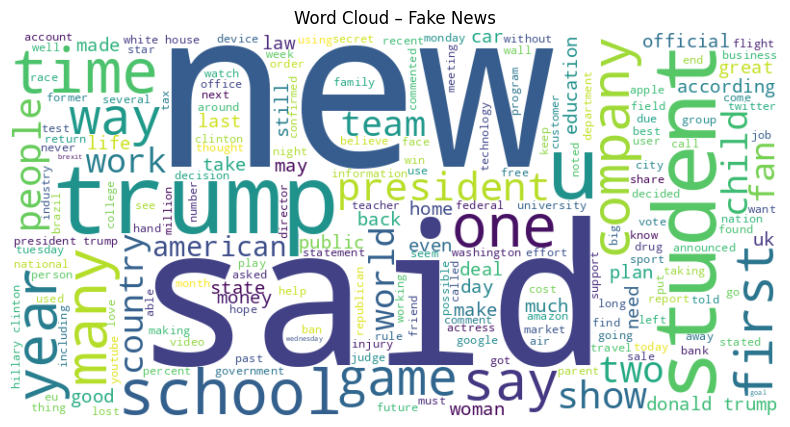

In [ ]:
# Visualisation: Word-cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fake_text = " ".join(df[df["label"] == 1]["clean_text"])

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color="white"
).generate(fake_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud – Fake News")
plt.show()

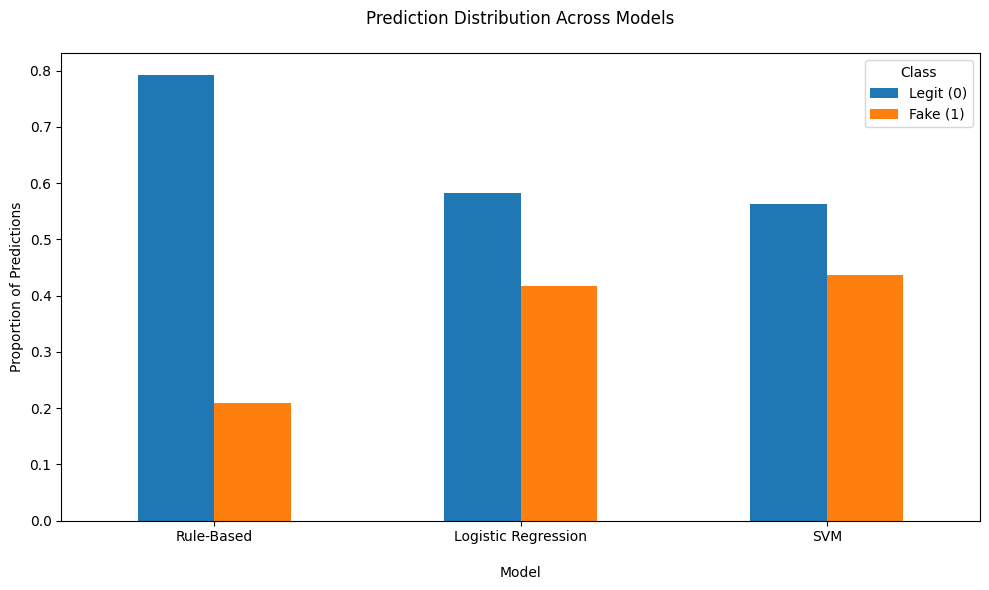

In [ ]:
# Create a DataFrame with predictions
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Rule-Based": rule_preds.values,
    "Logistic Regression": lr_preds,
    "SVM": svm_preds
})

pred_df.head()

# Compute Class Distribution per Model
def prediction_distribution(series):
    return series.value_counts(normalize=True).sort_index()

dist_df = pd.DataFrame({
    model: prediction_distribution(pred_df[model])
    for model in ["Rule-Based", "Logistic Regression", "SVM"]
})

# Rename index for clarity
dist_df.index = ["Legit (0)", "Fake (1)"]

dist_df

# Sentiment / Class Distribution Plot

dist_df.T.plot(
    kind="bar",
    figsize=(10, 6)
)

plt.title("Prediction Distribution Across Models\n")
plt.xlabel("\nModel")
plt.ylabel("Proportion of Predictions")
plt.xticks(rotation=0)
plt.legend(title="Class")
plt.tight_layout()
plt.show()